# XGBoost Modeling Workflow Overview

This notebook documents a comprehensive workflow for developing, optimizing, and interpreting an XGBoost classification model to predict drinking status (`DRK_YN`) based on medical and demographic features.

---

## Workflow Steps

### 1. Load Preprocessed Data  
We begin by loading the cleaned and feature-engineered datasets (`X_train_xgb`, `X_val_xgb`, `X_test_xgb`, and their corresponding labels) from pre-saved CSV files.

### 2. Baseline Model Training  
An initial XGBoost model is trained using default hyperparameters to establish baseline performance. Evaluation metrics include AUC, accuracy, precision, recall, F1-score, as well as confusion matrix and ROC curve visualizations.

### 3. Feature Importance Analysis  
The baseline model’s built-in feature importance scores are used to identify the most influential predictors. These insights help guide further dimensionality reduction and model interpretation.

### 4. Model Training with Selected Features  
The model is retrained using only the top N most important features. Validation performance is compared to the baseline to assess whether a simpler model can achieve similar results.

### 5. Hyperparameter Tuning with Optuna  
Optuna is employed for automated multi-objective hyperparameter optimization. The tuning process aims to maximize mean and minimize standard deviation for AUC, F1 score, and accuracy, using 5-fold cross-validation. The search space covers parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `reg_alpha`, and `reg_lambda`. All trial results are saved for further analysis, and the best parameter set is selected based on mean AUC.

### 6. Final Model Training with Optimized Parameters  
The model is retrained using the optimal hyperparameters identified by Optuna, and its performance is evaluated on both the validation and test sets.

### 7. Model Evaluation and Visualization  
A summary table is created to compare the performance of the baseline and tuned models across validation and test sets. Bar plots and other visualizations are included to facilitate direct comparison.

### 8. Model Interpretation with SHAP  
SHAP (SHapley Additive Explanations) is used to interpret the model’s predictions at the feature level. Both summary and bar plots are generated to provide transparency into the model’s decision-making process.

### 9. Error Analysis and Visualization  
Comprehensive error analysis is conducted using the model’s predictions. This includes identifying and visualizing different error types (TP, TN, FP, FN), analyzing feature distributions for error samples, projecting error types using PCA, and generating local SHAP explanations for selected samples.

### 10. Save Final Model  
The final trained model is saved as a `.pkl` file using joblib, making it available for deployment or future use.

# 1. Load Preprocessed Data

In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path("../data/processed")

# Load XGBoost datasets using relative paths
X_train_xgb = pd.read_csv(data_dir / "X_train_xgb.csv")
X_val_xgb = pd.read_csv(data_dir / "X_val_xgb.csv")
X_test_xgb = pd.read_csv(data_dir / "X_test_xgb.csv")

y_train_xgb = pd.read_csv(data_dir / "y_train_xgb.csv").squeeze() 
y_val_xgb = pd.read_csv(data_dir / "y_val_xgb.csv").squeeze()
y_test_xgb = pd.read_csv(data_dir / "y_test_xgb.csv").squeeze()

# Confirm shapes
print("Training set:", X_train_xgb.shape, y_train_xgb.shape)
print("Validation set:", X_val_xgb.shape, y_val_xgb.shape)
print("Test set:", X_test_xgb.shape, y_test_xgb.shape)

Training set: (693942, 35) (693942,)
Validation set: (148702, 35) (148702,)
Test set: (148702, 35) (148702,)


In [2]:
X_train_xgb

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,vision_avg,hearing_avg,AST_ALT_ratio,risk_waist,risk_bp,risk_tg,risk_chole,risk_glu,metabolic_risk_count,sex_Male
0,45.0,170.0,70.0,85.5,1.0,1.2,1.0,1.0,108.0,68.0,...,1.10,1.0,2.125000,1.0,0.0,0.0,1.0,0.0,2.0,False
1,55.0,160.0,65.0,79.0,0.8,0.7,1.0,1.0,114.0,68.0,...,0.75,1.0,1.384615,0.0,0.0,0.0,1.0,1.0,2.0,False
2,55.0,155.0,80.0,101.9,0.9,1.0,1.0,1.0,116.0,67.0,...,0.95,1.0,0.736842,1.0,0.0,1.0,0.0,1.0,3.0,False
3,65.0,150.0,55.0,75.0,0.9,0.8,1.0,1.0,136.0,84.0,...,0.85,1.0,1.400000,0.0,1.0,1.0,1.0,0.0,3.0,False
4,40.0,155.0,60.0,85.0,0.9,1.2,1.0,1.0,117.0,69.0,...,1.05,1.0,1.545455,1.0,0.0,0.0,1.0,1.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693937,55.0,155.0,55.0,78.0,0.3,0.5,1.0,1.0,113.0,71.0,...,0.40,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,False
693938,40.0,175.0,90.0,86.0,0.9,1.0,1.0,1.0,105.0,65.0,...,0.95,1.0,1.172414,0.0,0.0,1.0,1.0,1.0,3.0,True
693939,60.0,170.0,75.0,92.0,2.0,1.2,1.0,1.0,126.0,80.0,...,1.60,1.0,0.916667,1.0,0.0,0.0,0.0,1.0,2.0,True
693940,55.0,170.0,85.0,92.0,0.8,0.7,1.0,1.0,130.0,80.0,...,0.75,1.0,0.676471,1.0,1.0,1.0,1.0,1.0,5.0,True


In [3]:
X_train_xgb.head(), y_train_xgb.head()

(    age  height  weight  waistline  sight_left  sight_right  hear_left  \
 0  45.0   170.0    70.0       85.5         1.0          1.2        1.0   
 1  55.0   160.0    65.0       79.0         0.8          0.7        1.0   
 2  55.0   155.0    80.0      101.9         0.9          1.0        1.0   
 3  65.0   150.0    55.0       75.0         0.9          0.8        1.0   
 4  40.0   155.0    60.0       85.0         0.9          1.2        1.0   
 
    hear_right    SBP   DBP  ...  vision_avg  hearing_avg  AST_ALT_ratio  \
 0         1.0  108.0  68.0  ...        1.10          1.0       2.125000   
 1         1.0  114.0  68.0  ...        0.75          1.0       1.384615   
 2         1.0  116.0  67.0  ...        0.95          1.0       0.736842   
 3         1.0  136.0  84.0  ...        0.85          1.0       1.400000   
 4         1.0  117.0  69.0  ...        1.05          1.0       1.545455   
 
    risk_waist  risk_bp  risk_tg  risk_chole  risk_glu  metabolic_risk_count  \
 0        

In [4]:
y_train_xgb

0         0
1         0
2         0
3         0
4         0
         ..
693937    0
693938    1
693939    1
693940    1
693941    0
Name: DRK_YN, Length: 693942, dtype: int64

# 2. Baseline XGBoost Model 

- This section trains a baseline XGBoost classifier on the training data and evaluates its performance on the validation set. It computes key classification metrics—including AUC, accuracy, precision, recall, and F1-score—and displays a detailed classification report. The results are further visualized using a confusion matrix heatmap and an ROC curve.

Validation Set Performance (Baseline):
AUC:        0.8212
Accuracy:   0.7387
Precision:  0.7371
Recall:     0.7419
F1 Score:   0.7395

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74     74379
           1       0.74      0.74      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



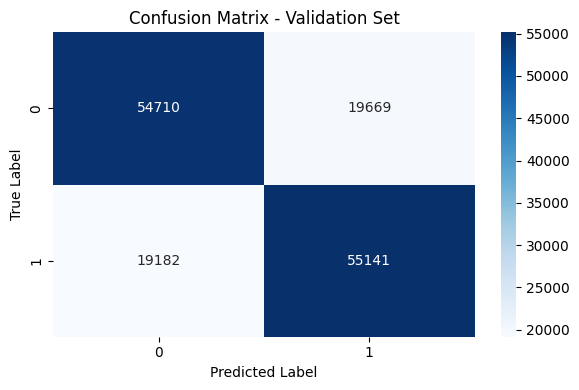

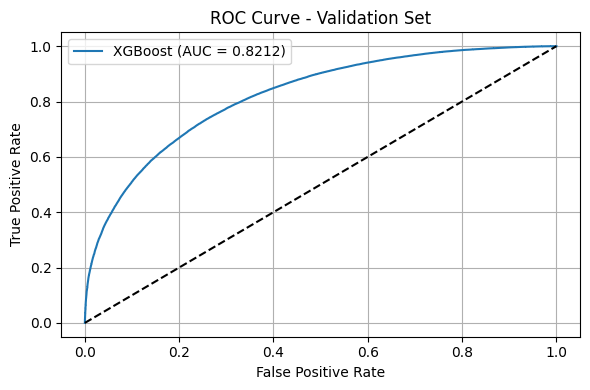

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize baseline model
baseline_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Train the model
baseline_model.fit(X_train_xgb, y_train_xgb)

# Predict on validation set
y_val_proba = baseline_model.predict_proba(X_val_xgb)[:, 1]
y_val_pred = baseline_model.predict(X_val_xgb)

# Evaluation metrics
val_auc = roc_auc_score(y_val_xgb, y_val_proba)
val_acc = accuracy_score(y_val_xgb, y_val_pred)
val_precision = precision_score(y_val_xgb, y_val_pred)
val_recall = recall_score(y_val_xgb, y_val_pred)
val_f1 = f1_score(y_val_xgb, y_val_pred)
conf_mat = confusion_matrix(y_val_xgb, y_val_pred)

# Print results
print("Validation Set Performance (Baseline):")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val_xgb, y_val_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val_xgb, y_val_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
y_val_pred_base = y_val_pred
y_val_proba_base = y_val_proba

### Summary and Evaluation of Baseline XGBoost Model Performance
- The baseline XGBoost classifier achieves an AUC of 0.8212 and an overall accuracy of 73.87% on the validation set. Precision, recall, and F1-score are all balanced around 0.74, indicating consistent performance across both classes. The classification report further confirms that the model does not exhibit significant bias toward either class, with similar precision and recall for both positive and negative cases.
- The confusion matrix shows that the model correctly classifies the majority of both positive and negative samples, with 54,710 true negatives and 55,141 true positives. However, there is a notable number of false positives (19,669) and false negatives (19,182). This suggests that while the model is effective, there is still room for improvement, particularly in reducing misclassifications.
- The ROC curve demonstrates good discriminative ability, with the curve well above the diagonal, and the AUC value further supports the model’s strong performance.


# 3. Feature Importance Analysis

- The feature importance analysis extracts and ranks the most influential predictors used by the baseline XGBoost model. The top 10 features are visualized using a horizontal bar plot, providing clear insight into which variables contribute most to the model’s predictions. 

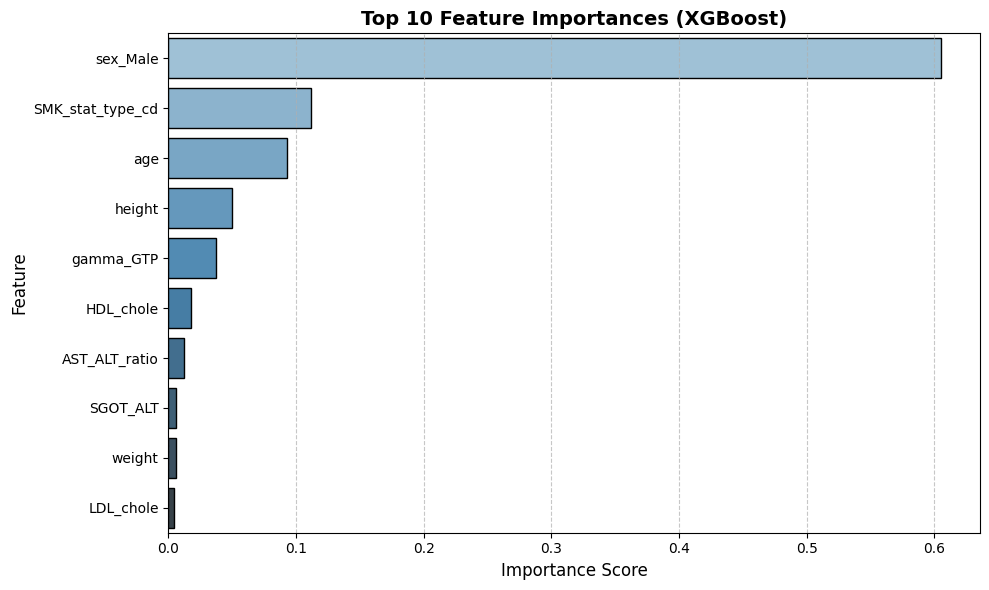

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances
importances = baseline_model.feature_importances_
feature_names = X_train_xgb.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10 features
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=top_features,
    palette='Blues_d',
    edgecolor='black',
    legend=False  
)

plt.title('Top 10 Feature Importances (XGBoost)', fontsize=14, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The feature importance plot reveals that sex_Male is by far the most influential predictor in the XGBoost model, followed by age and SMK_stat_type_cd (smoking status). Other notable features include height, gamma_GTP, and various cholesterol-related variables. The dominance of demographic and lifestyle factors, particularly gender and age, suggests that these attributes play a critical role in predicting drinking status within this dataset. The remaining features contribute to a lesser extent, indicating that the model relies primarily on a few key variables for its predictions.

# 4. Model Performance with Selected Features

## Optimal Feature Subset Selection
- This section evaluates model performance as a function of the number of top-ranked features. By incrementally adding features based on their importance and recording the validation AUC for each subset, it identifies the optimal number of features that yields the highest predictive performance. The results are visualized in a line plot, and the best-performing feature count is reported for further model development.

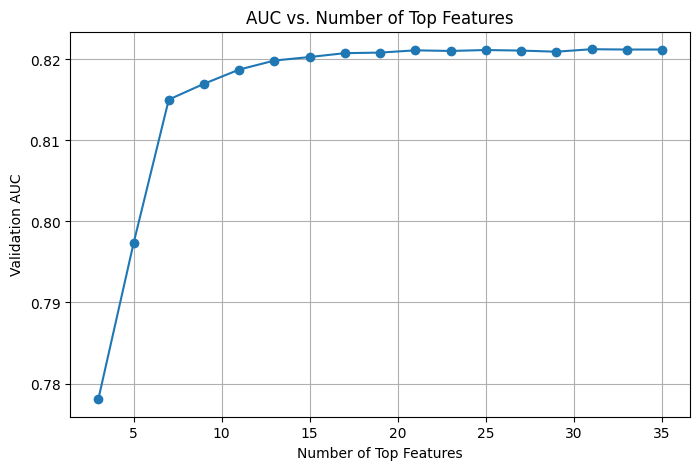

Best number of features: 31, Best AUC: 0.8213


In [8]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

auc_scores = []
feature_range = range(3, len(importance_df)+1, 2) 

for n in feature_range:
    top_features = importance_df.head(n)['Feature'].tolist()
    X_train_sel = X_train_xgb[top_features]
    X_val_sel = X_val_xgb[top_features]
    
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train_sel, y_train_xgb)
    y_val_proba = model.predict_proba(X_val_sel)[:, 1]
    auc = roc_auc_score(y_val_xgb, y_val_proba)
    auc_scores.append(auc)

# visualize the AUC vs. Number of Top Features
plt.figure(figsize=(8,5))
plt.plot(feature_range, auc_scores, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Validation AUC')
plt.title('AUC vs. Number of Top Features')
plt.grid(True)
plt.show()

# Find the number of features with the highest AUC
best_n = feature_range[np.argmax(auc_scores)]
print(f"Best number of features: {best_n}, Best AUC: {max(auc_scores):.4f}")

- The XGBoost model is retrained using the optimal feature subset and evaluated on the validation and test sets. Performance metrics and visualizations, including the confusion matrix and ROC curve, provide a clear assessment of the model’s effectiveness.

Validation Set:
AUC: 0.8213
Accuracy: 0.7386
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74     74379
           1       0.74      0.74      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



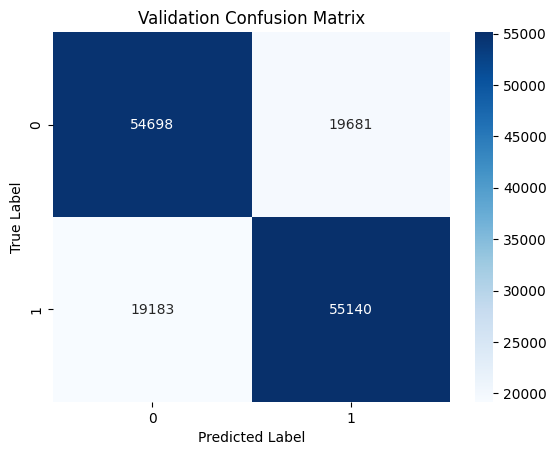

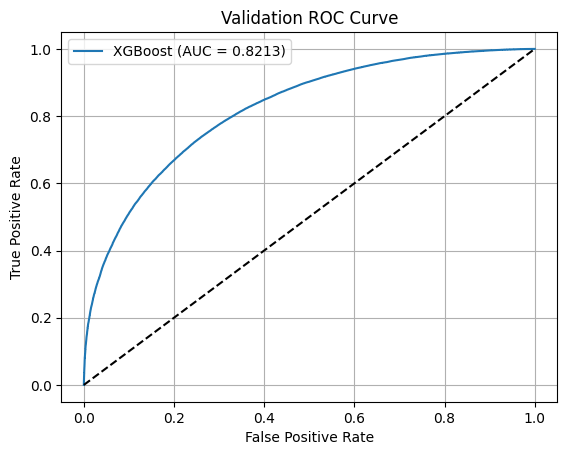

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report, 
    confusion_matrix, roc_curve
)
from xgboost import XGBClassifier

# Select top best_n features
selected_features = importance_df.head(best_n)['Feature'].tolist()
X_train_sel = X_train_xgb[selected_features]
X_val_sel = X_val_xgb[selected_features]
X_test_sel = X_test_xgb[selected_features]

#  Train model
selected_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
selected_model.fit(X_train_sel, y_train_xgb)

#  Predictions
y_val_proba = selected_model.predict_proba(X_val_sel)[:, 1]
y_val_pred = selected_model.predict(X_val_sel)
y_test_proba = selected_model.predict_proba(X_test_sel)[:, 1]
y_test_pred = selected_model.predict(X_test_sel)

#  Evaluation scores
print("Validation Set:")
print(f"AUC: {roc_auc_score(y_val_xgb, y_val_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_val_xgb, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val_xgb, y_val_pred))

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val_xgb, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve - Validation
fpr, tpr, _ = roc_curve(y_val_xgb, y_val_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.4f)' % roc_auc_score(y_val_xgb, y_val_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Validation ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

- The feature-selected XGBoost model achieves an AUC of 0.8213 and an accuracy of 73.86% on the validation set, which closely matches the baseline model. Key metrics such as precision, recall, and F1-score remain balanced at 0.74 for both classes. The confusion matrix results are also very similar to the baseline, indicating that reducing the number of features maintains predictive performance while improving model simplicity.

In [10]:
y_val_pred_fs = y_val_pred
y_val_proba_fs = y_val_proba

# 5. Hyperparameter Tuning with Optuna

In [11]:
!pip install optuna

- This section applies Optuna to perform multi-objective hyperparameter optimization for the XGBoost model using 5-fold cross-validation. The optimization simultaneously maximizes mean and minimizes standard deviation for AUC, F1 score, and accuracy. All trial results are saved, and the best parameter set is selected based on mean AUC.

In [12]:
import optuna
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from xgboost import XGBClassifier

os.makedirs('results', exist_ok=True)

results_list = []

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs, f1s, accs = [], [], []
    for train_idx, val_idx in skf.split(X_train_xgb, y_train_xgb):
        X_tr, X_val = X_train_xgb.iloc[train_idx], X_train_xgb.iloc[val_idx]
        y_tr, y_val = y_train_xgb.iloc[train_idx], y_train_xgb.iloc[val_idx]
        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_proba))
        f1s.append(f1_score(y_val, y_pred))
        accs.append(accuracy_score(y_val, y_pred))
    # Record trial results
    trial_result = {
        **params,
        'mean_auc': np.mean(aucs),
        'std_auc': np.std(aucs),
        'mean_f1': np.mean(f1s),
        'std_f1': np.std(f1s),
        'mean_acc': np.mean(accs),
        'std_acc': np.std(accs)
    }
    results_list.append(trial_result)
    # Multi-objective: maximize mean, minimize std
    return np.mean(aucs), np.std(aucs), np.mean(f1s), np.std(f1s), np.mean(accs), np.std(accs)

# Multi-objective directions
study = optuna.create_study(directions=['maximize', 'minimize', 'maximize', 'minimize', 'maximize', 'minimize'])
study.optimize(objective, n_trials=30)

results_df = pd.DataFrame(results_list)
results_df.to_csv('../results/xgb_multiobjective_trials.csv', index=False)

# Select best parameters by mean AUC
best_idx = results_df['mean_auc'].idxmax()
best_params = results_df.loc[best_idx]
print("Best parameters (by mean_auc):")
print(best_params)

[I 2025-05-13 23:09:18,198] A new study created in memory with name: no-name-008ba041-1fb6-429c-861f-62fb68da9f6f
[I 2025-05-13 23:09:32,875] Trial 0 finished with values: [0.8219112620915798, 0.0009086836853396447, 0.7394761295127144, 0.0010900464797620505, 0.7389061340621741, 0.0009452632364713706] and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.18497779140945037, 'subsample': 0.879728927129255, 'colsample_bytree': 0.860670362418831, 'reg_alpha': 0.40742249261088503, 'reg_lambda': 0.5839655666796287}.
[I 2025-05-13 23:09:42,292] Trial 1 finished with values: [0.8205881401593109, 0.0008993826702148072, 0.7377325356108073, 0.0008120802046626626, 0.7373699818429893, 0.0007317213388396051] and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.25581129998532515, 'subsample': 0.7568753013312831, 'colsample_bytree': 0.894523411599935, 'reg_alpha': 0.20253176393736216, 'reg_lambda': 0.9415364739485383}.
[I 2025-05-13 23:10:03,475] Trial 2 finished 

Best parameters (by mean_auc):
objective           binary:logistic
eval_metric                 logloss
random_state                     42
n_estimators                    223
max_depth                         8
learning_rate              0.033309
subsample                   0.80396
colsample_bytree           0.738361
reg_alpha                  0.340486
reg_lambda                 0.787533
mean_auc                   0.822661
std_auc                    0.000809
mean_f1                    0.740218
std_f1                     0.001503
mean_acc                   0.739386
std_acc                    0.001327
Name: 11, dtype: object


In [13]:
results_df

,objective,eval_metric,random_state,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,mean_auc,std_auc,mean_f1,std_f1,mean_acc,std_acc
0,binary:logistic,logloss,42,247,5,0.184978,0.879729,0.860670,0.407422,0.583966,0.821911,0.000909,0.739476,0.001090,0.738906,0.000945
1,binary:logistic,logloss,42,120,6,0.255811,0.756875,0.894523,0.202532,0.941536,0.820588,0.000899,0.737733,0.000812,0.737370,0.000732
2,binary:logistic,logloss,42,267,6,0.103551,0.758889,0.704688,0.799575,0.123621,0.822427,0.000811,0.739935,0.001302,0.739585,0.001067
3,binary:logistic,logloss,42,338,9,0.219392,0.541751,0.783150,0.274844,0.087766,0.801779,0.001077,0.722056,0.001463,0.722595,0.001191
4,binary:logistic,logloss,42,437,8,0.237866,0.882536,0.701902,0.769336,0.172371,0.810210,0.000716,0.729194,0.001161,0.729675,0.001031
5,binary:logistic,logloss,42,422,10,0.086942,0.934422,0.890746,0.270639,0.652412,0.818296,0.000897,0.735376,0.001069,0.735782,0.000867
6,binary:logistic,logloss,42,133,6,0.177933,0.779270,0.603038,0.927114,0.959180,0.821907,0.000808,0.739261,0.001087,0.738794,0.001009
7,binary:logistic,logloss,42,319,5,0.059780,0.583315,0.765307,0.795482,0.348966,0.822521,0.000802,0.740557,0.001089,0.739396,0.000924
8,binary:logistic,logloss,42,365,5,0.153242,0.709282,0.566376,0.508930,0.371994,0.821884,0.000841,0.739334,0.001715,0.738833,0.001454
9,binary:logistic,logloss,42,226,5,0.066106,0.557683,0.821874,0.779584,0.549039,0.822294,0.000800,0.740711,0.000890,0.739245,0.000694


# 6. Final Model Training with Best Parameters

- This section selects the best hyperparameter set from the Pareto optimal trials, retrains the XGBoost model on the full training set, and evaluates its performance on both validation and test sets. Key metrics and visualizations—including the confusion matrix and ROC curve—are provided to assess the tuned model’s effectiveness.

Validation Set Performance (Tuned):
AUC: 0.8232
Accuracy: 0.7407
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.75      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



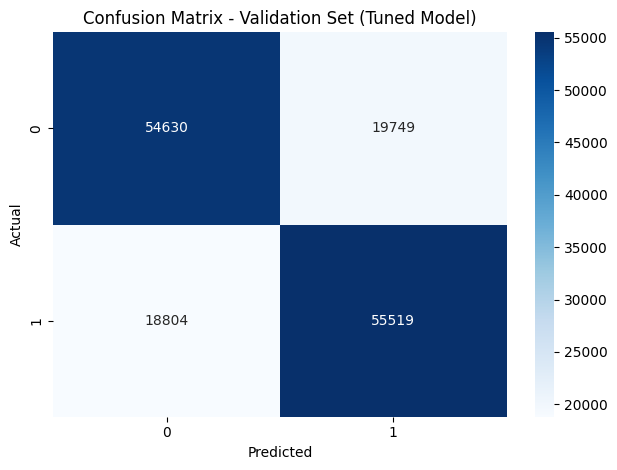

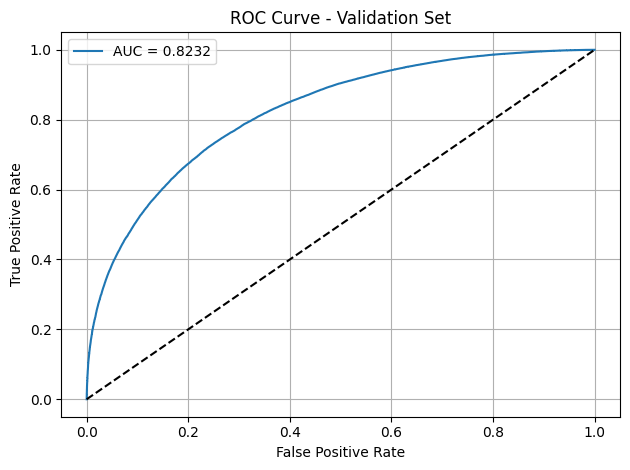

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Get all Pareto optimal solutions
pareto_trials = study.best_trials

# Select the trial with the highest mean AUC
best_trial = max(pareto_trials, key=lambda t: t.values[0]) 

best_params = best_trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
})

# Retrain on training set
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_xgb, y_train_xgb)

# Predict on validation and test sets
y_val_proba = final_model.predict_proba(X_val_xgb)[:, 1]
y_val_pred = final_model.predict(X_val_xgb)

y_test_proba = final_model.predict_proba(X_test_xgb)[:, 1]
y_test_pred = final_model.predict(X_test_xgb)

# Evaluation (Validation Set)
print("Validation Set Performance (Tuned):")
print(f"AUC: {roc_auc_score(y_val_xgb, y_val_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_val_xgb, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val_xgb, y_val_pred))

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val_xgb, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix - Validation Set (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve - Validation
fpr, tpr, _ = roc_curve(y_val_xgb, y_val_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val_xgb, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
y_val_pred_tuned = y_val_pred
y_val_proba_tuned = y_val_proba
y_test_pred_tuned = y_test_pred
y_test_proba_tuned = y_test_proba

### Comparison of Tuned, Baseline, and Feature-Selected XGBoost Models
- The tuned XGBoost model achieves a slightly higher AUC (0.8232) and accuracy (74.07%) on the validation set compared to both the baseline model (AUC 0.8213, accuracy 73.86%) and the feature-selected model (AUC 0.8213, accuracy 73.86%). Precision, recall, and F1-score remain balanced at 0.74 across all models. The tuned model shows a modest reduction in both false positives (19,749) and false negatives (18,804) compared to the baseline and feature-selected models, as reflected in the confusion matrix.
### *Conclusion:*
- Hyperparameter optimization leads to a measurable improvement in model performance, surpassing both the baseline and feature-selected models. This demonstrates that careful tuning, in addition to feature selection, can further enhance predictive accuracy and overall model effectiveness.

# 7. Model Evaluation and Visualization

- These sections compute and summarize key evaluation metrics (AUC, accuracy, precision, recall, and F1 score) for the baseline, feature-selected, and tuned XGBoost models on both validation and test sets. The results are presented in a comparison table and visualized using a grouped bar plot, providing a clear and direct comparison of model performance across different configurations.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve
)

# Create a comparison DataFrame for key metrics
comparison_df = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Baseline (Val)': [
        roc_auc_score(y_val_xgb, y_val_proba_base),
        accuracy_score(y_val_xgb, y_val_pred_base),
        precision_score(y_val_xgb, y_val_pred_base),
        recall_score(y_val_xgb, y_val_pred_base),
        f1_score(y_val_xgb, y_val_pred_base)
    ],
    'Feature-Selected (Val)': [
        roc_auc_score(y_val_xgb, y_val_proba_fs),
        accuracy_score(y_val_xgb, y_val_pred_fs),
        precision_score(y_val_xgb, y_val_pred_fs),
        recall_score(y_val_xgb, y_val_pred_fs),
        f1_score(y_val_xgb, y_val_pred_fs)
    ],
    'Tuned (Val)': [
        roc_auc_score(y_val_xgb, y_val_proba_tuned),
        accuracy_score(y_val_xgb, y_val_pred_tuned),
        precision_score(y_val_xgb, y_val_pred_tuned),
        recall_score(y_val_xgb, y_val_pred_tuned),
        f1_score(y_val_xgb, y_val_pred_tuned)
    ],
    'Tuned (Test)': [
        roc_auc_score(y_test_xgb, y_test_proba),
        accuracy_score(y_test_xgb, y_test_pred),
        precision_score(y_test_xgb, y_test_pred),
        recall_score(y_test_xgb, y_test_pred),
        f1_score(y_test_xgb, y_test_pred)
    ]
})

# Round results for better readability
comparison_df.iloc[:, 1:] = comparison_df.iloc[:, 1:].round(4)

print(comparison_df)

      Metric  Baseline (Val)  Feature-Selected (Val)  Tuned (Val)  \
0        AUC          0.8212                  0.8213       0.8232   
1   Accuracy          0.7387                  0.7386       0.7407   
2  Precision          0.7371                  0.7370       0.7376   
3     Recall          0.7419                  0.7419       0.7470   
4   F1 Score          0.7395                  0.7394       0.7423   

   Tuned (Test)  
0        0.8247  
1        0.7415  
2        0.7402  
3        0.7441  
4        0.7421  


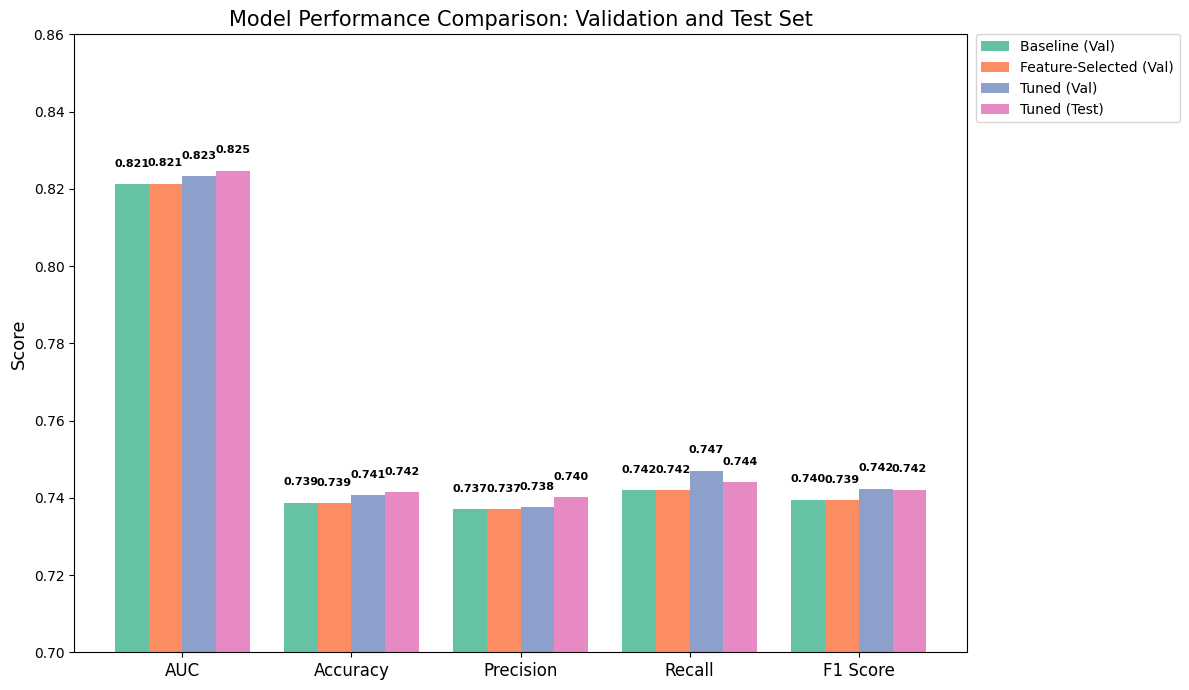

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("Set2", 4)

plt.figure(figsize=(12, 7))
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
x = range(len(metrics))
bar_width = 0.2

bars1 = plt.bar(x, comparison_df['Baseline (Val)'], width=bar_width, label='Baseline (Val)', align='center', color=palette[0])
bars2 = plt.bar([i + bar_width for i in x], comparison_df['Feature-Selected (Val)'], width=bar_width, label='Feature-Selected (Val)', align='center', color=palette[1])
bars3 = plt.bar([i + 2*bar_width for i in x], comparison_df['Tuned (Val)'], width=bar_width, label='Tuned (Val)', align='center', color=palette[2])
bars4 = plt.bar([i + 3*bar_width for i in x], comparison_df['Tuned (Test)'], width=bar_width, label='Tuned (Test)', align='center', color=palette[3])

plt.xticks([i + 1.5*bar_width for i in x], metrics, fontsize=12)
plt.ylabel('Score', fontsize=13)
plt.title('Model Performance Comparison: Validation and Test Set', fontsize=15)
plt.ylim(0.7, 0.86) 
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=10)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height + 0.004,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold'
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.show()

### Model Comparison Summary
- *Baseline Model*:
Achieves an AUC of 0.8212 and an accuracy of 73.87% on the validation set. Precision, recall, and F1 score are all balanced around 0.74.
- *Feature-Selected Model*:
Maintains similar performance to the baseline, with an AUC of 0.8213 and an accuracy of 73.86%. Other metrics remain nearly unchanged, indicating that reducing the number of features does not compromise predictive power.
- *Tuned Model*:
Shows improved performance, with an AUC of 0.8232 and an accuracy of 74.07% on the validation set. Recall and F1 score also increase slightly, demonstrating the benefit of hyperparameter optimization.
- *Tuned Model (Test Set)*:
Generalizes well to the test set, achieving an AUC of 0.8247 and an accuracy of 74.15%, with balanced precision, recall, and F1 score.
#### Conclusion:
Feature selection maintains model simplicity without sacrificing performance, while hyperparameter tuning provides a measurable boost in predictive accuracy and generalization.

# 8. SHAP Model Interpretation

- This section uses SHAP to interpret the final XGBoost model. SHAP values are computed for the validation set, and both summary and bar plots are generated to visualize feature contributions and overall importance.

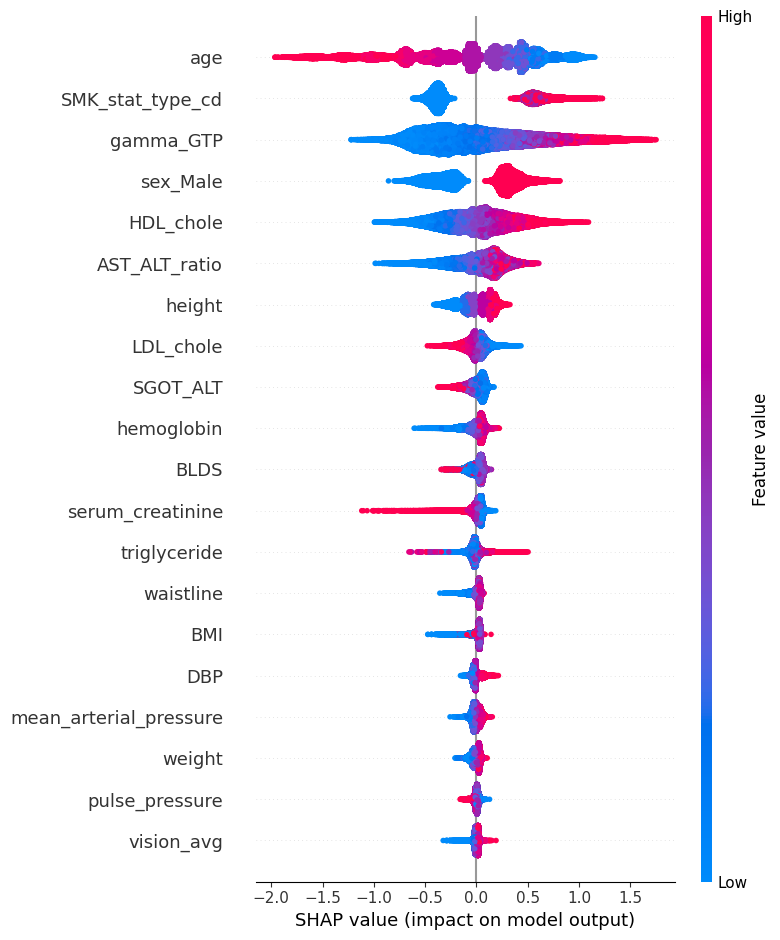

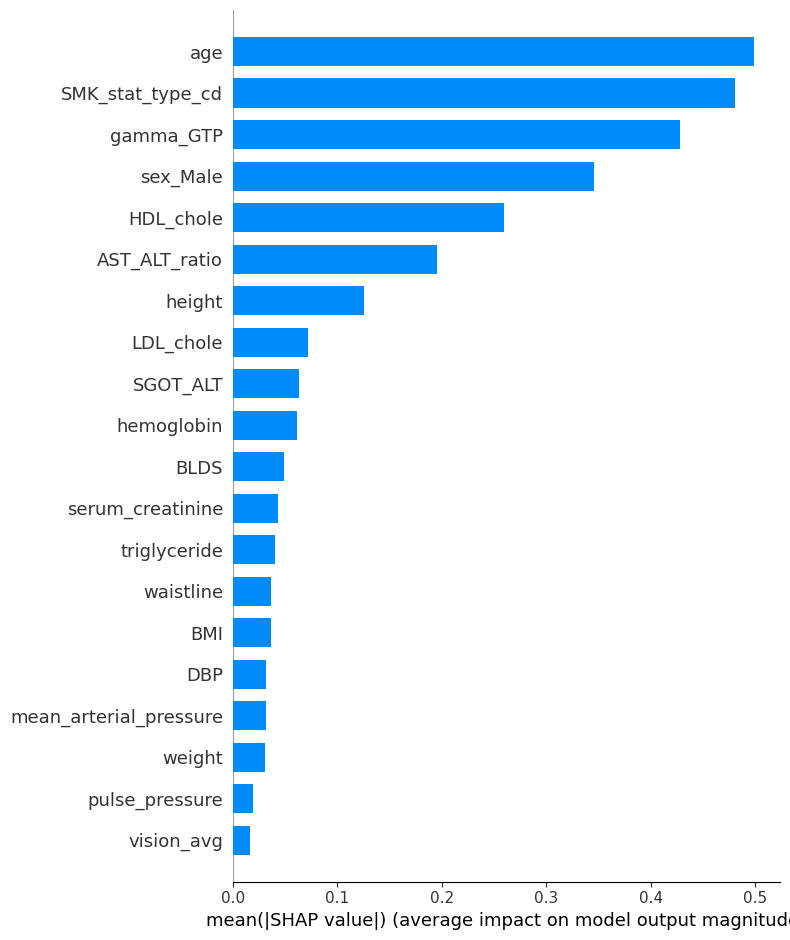

In [ ]:
import shap

explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_val_xgb)

shap.summary_plot(shap_values, X_val_xgb)

shap.summary_plot(shap_values, X_val_xgb, plot_type='bar')

### SHAP Summary Plot Analysis (XGBoost)

The SHAP summary and feature importance plots for the XGBoost model highlight the most influential features in predicting alcohol consumption:

- **Top Features:**  
  The most impactful features are `age`, `SMK_stat_type_cd` (smoking status), and `gamma_GTP` (a liver enzyme), followed closely by `sex_Male` and `HDL_chole` (high-density lipoprotein cholesterol). This indicates that demographic factors (age, sex), lifestyle factors (smoking), and certain health indicators (liver function and cholesterol levels) play a central role in the model’s predictions.

- **Feature Impact Patterns:**  
  Higher values of `age`, `SMK_stat_type_cd`, and `gamma_GTP` (shown in red) are associated with an increased likelihood of being classified as a drinker, while lower values (blue) reduce this likelihood. Similarly, being male (`sex_Male`) and having higher `HDL_chole` also contribute positively to the prediction. These patterns are consistent with known medical and lifestyle risk factors for alcohol consumption.

- **Interpretability:**  
  The SHAP value distributions are smooth and continuous, suggesting that the model captures nuanced, non-linear relationships between features and the target. The clear ranking and separation of feature importance indicate stable and interpretable model behavior.

**Conclusion:**  
- The XGBoost model demonstrates strong sensitivity to a small set of high-impact variables, with clear and medically plausible directionality in its predictions. This enhances both the interpretability and reliability of the model in identifying key factors associated with alcohol consumption.

# 9. Error Analysis

- This section calls a reusable error analysis pipeline to evaluate the XGBoost model’s validation predictions. It generates visualizations and statistics for different error types, analyzes feature distributions, and—if a SHAP explainer is provided—includes global and local interpretability insights. The results are returned as a structured dictionary for further review.

Visualizing Error Types (Confusion Matrix & PCA)...


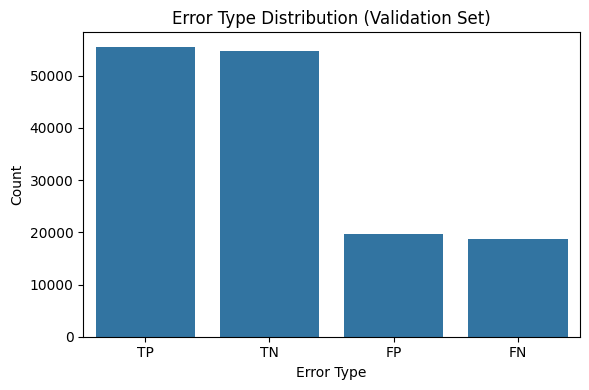

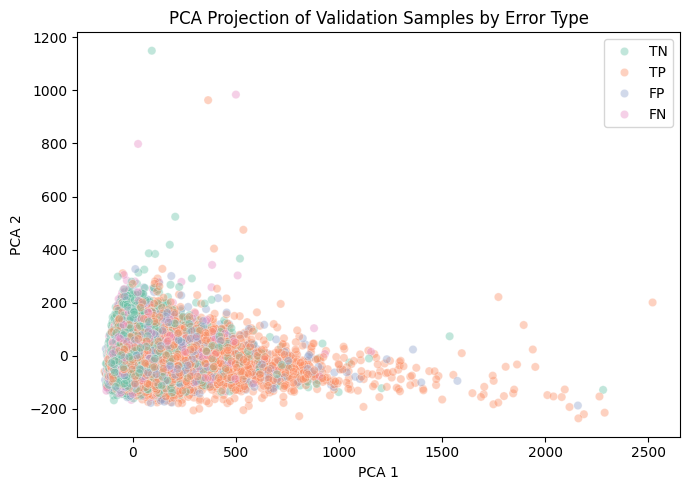


 Analyzing Error Samples (FN and FP)...

 Plotting Feature Distributions (FN)...


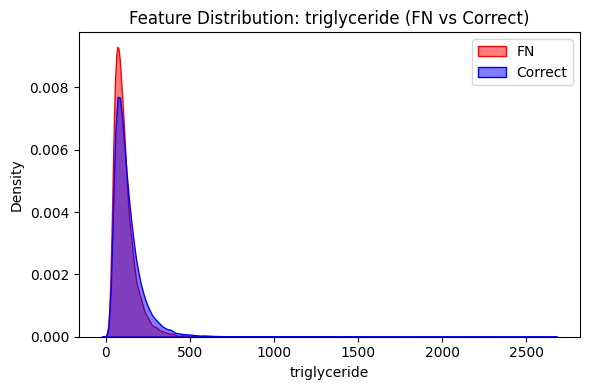

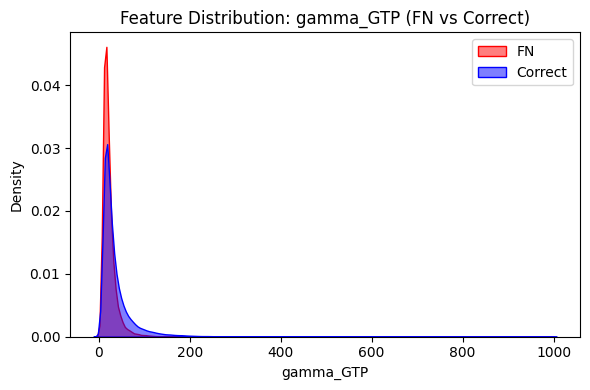

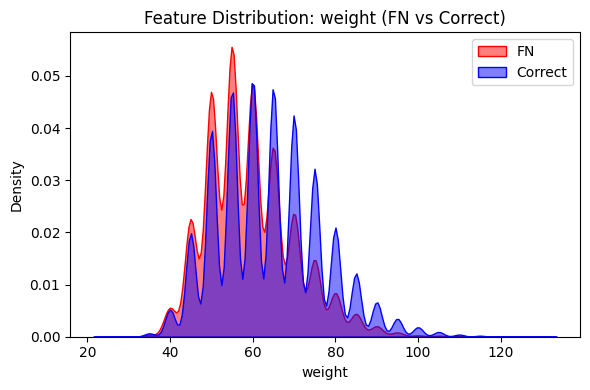


 Plotting Feature Distributions (FP)...


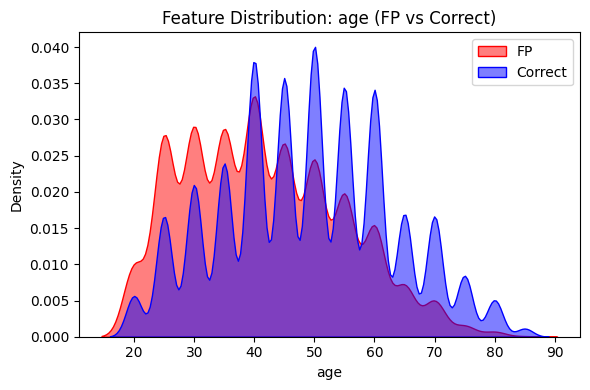

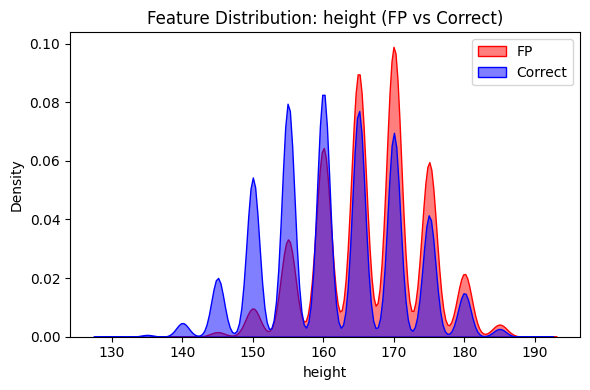

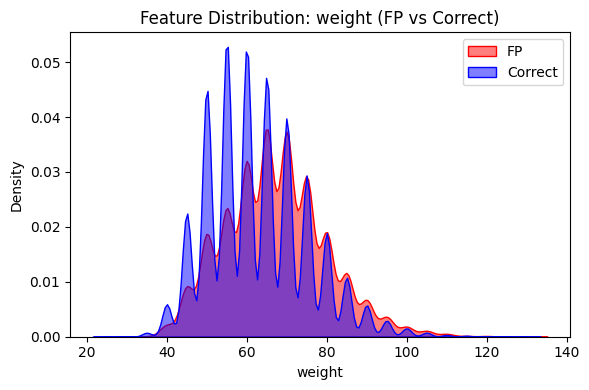


 SHAP Feature Importance and Distributions...


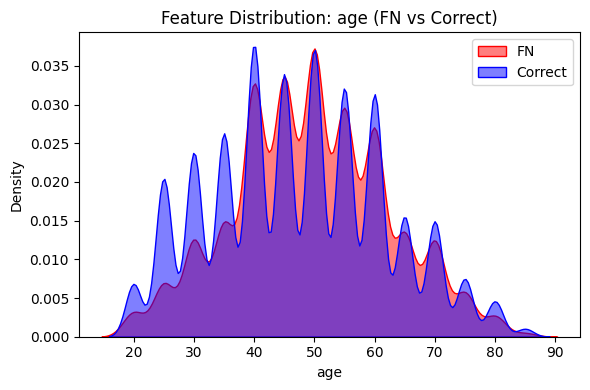

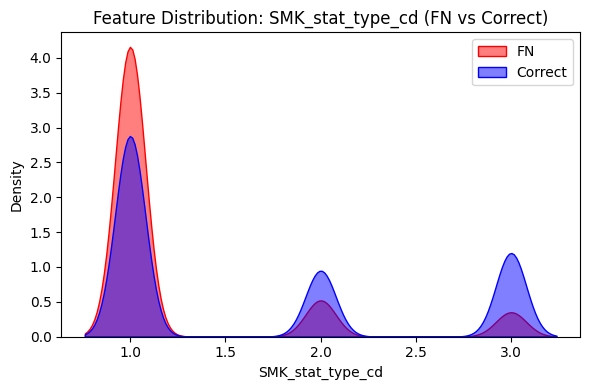

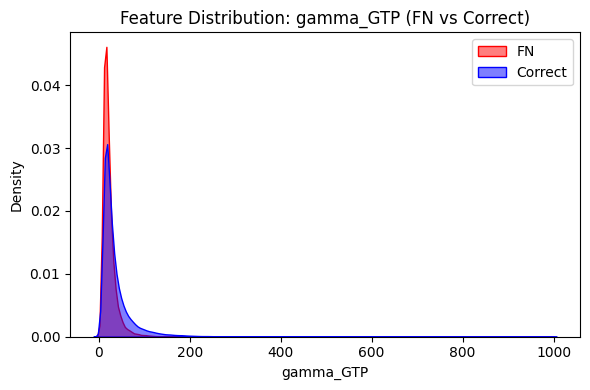

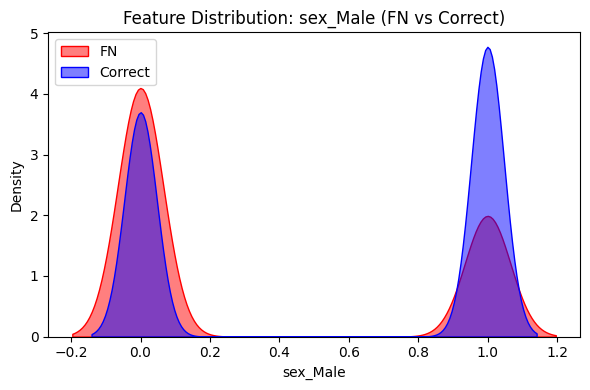

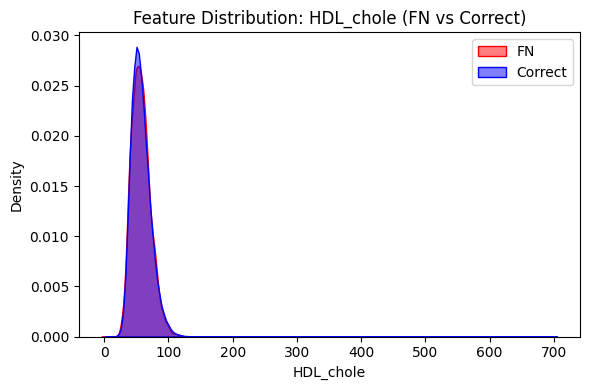

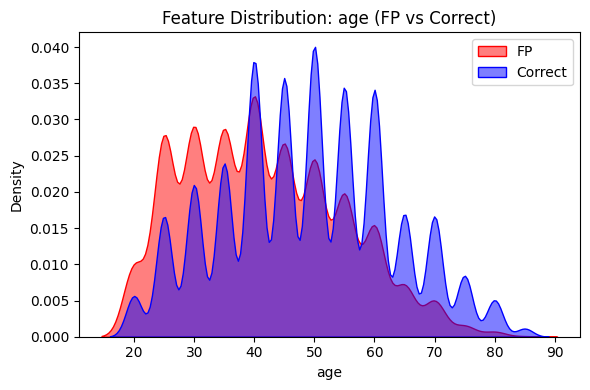

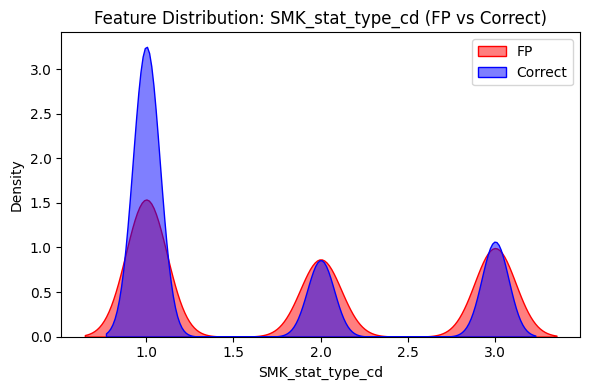

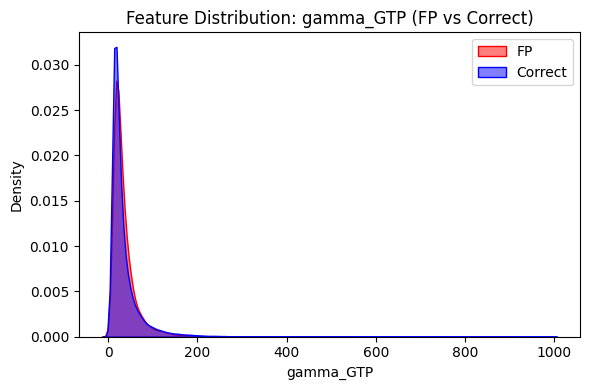

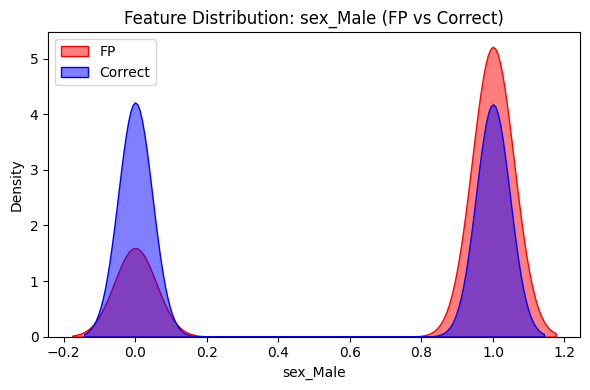

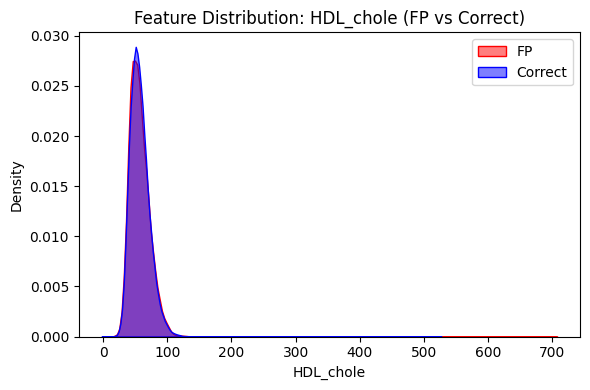


6. Analyzing Error Patterns (Pairplot)...


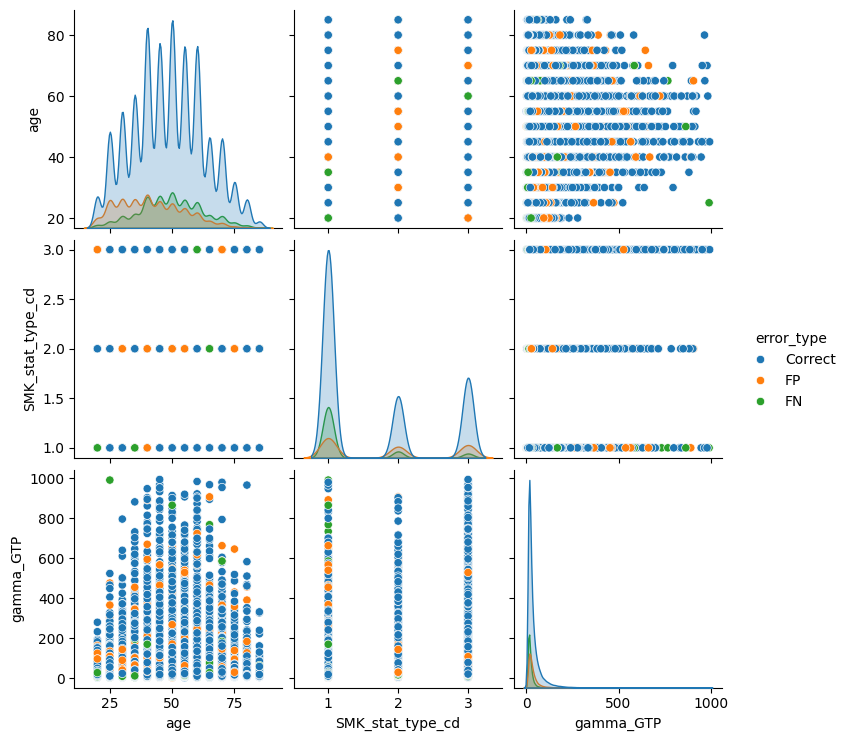


7. Generating Local Explanations (SHAP)...



FN Sample 88203:


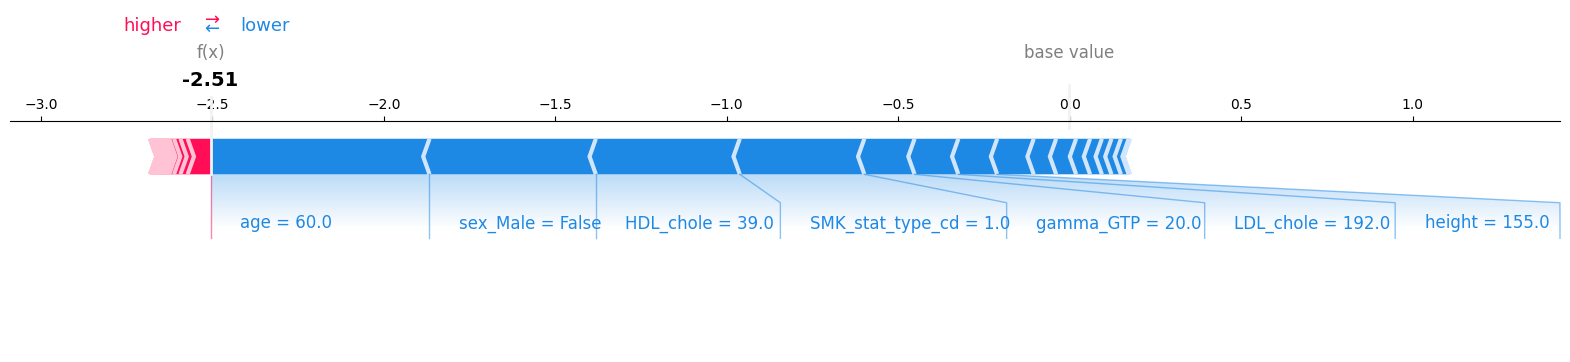


FN Sample 40968:


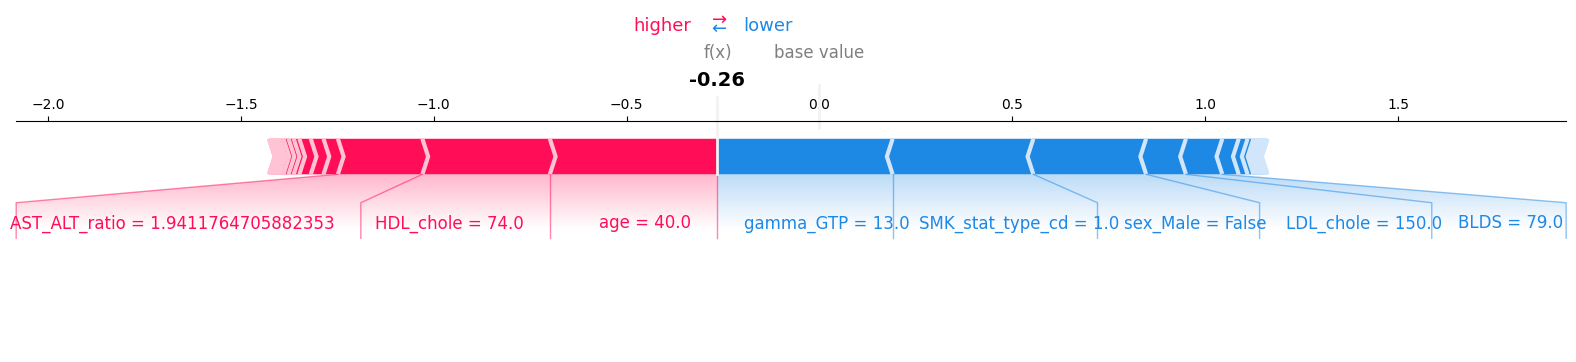


FN Sample 15684:


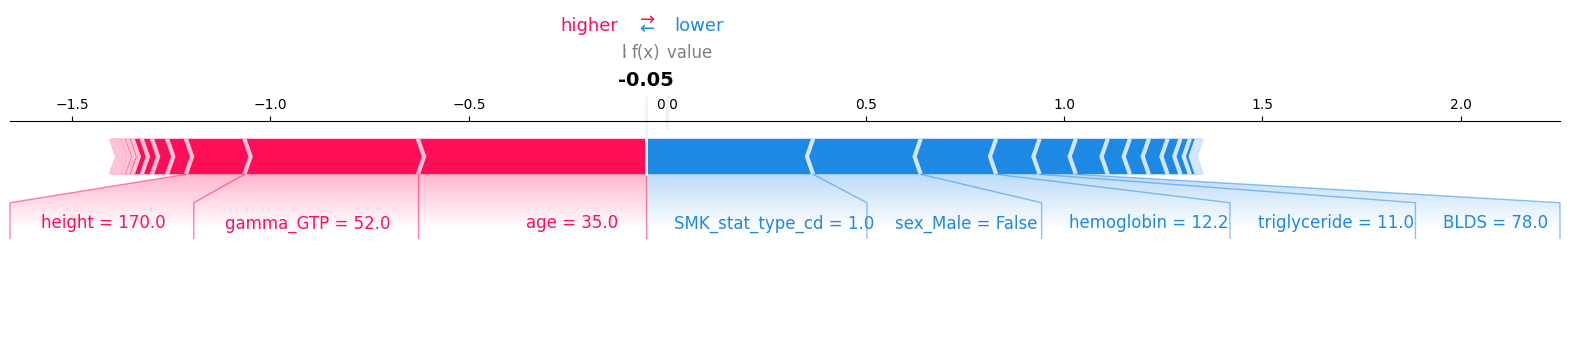


FP Sample 108634:


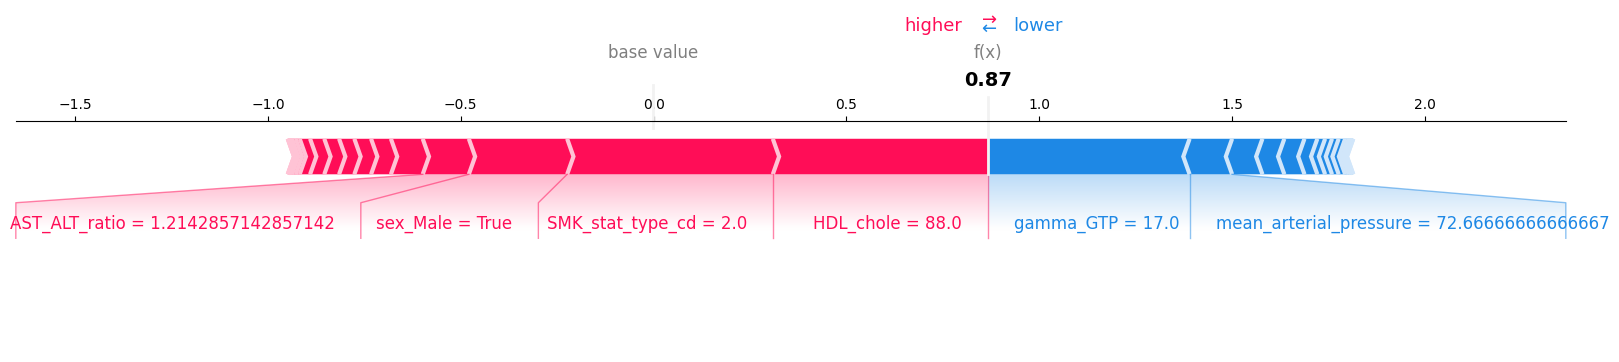


FP Sample 13841:


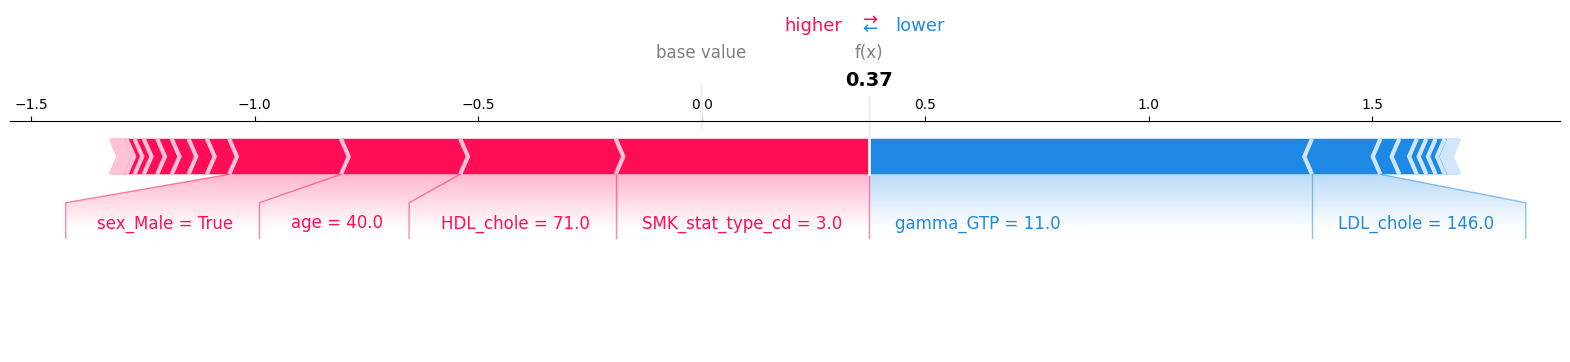


FP Sample 3519:


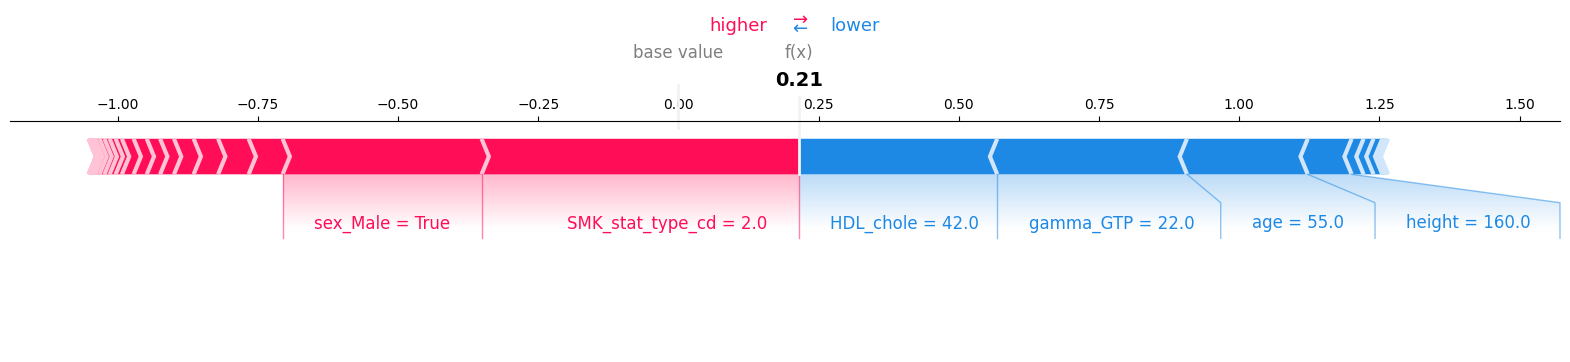

In [25]:
import sys

sys.path.append('../scripts')

from evaluate_models import run_error_analysis

results_xgb = run_error_analysis(X_val_xgb, y_val_xgb, y_val_pred, explainer=explainer)

#### 1. Error Type Distribution:
The validation set shows a balanced number of true positives (TP) and true negatives (TN), with both false positives (FP) and false negatives (FN) occurring at similar but lower frequencies. This indicates that the model does not exhibit a strong bias toward either class, but there is still a notable amount of misclassification.
#### 2. PCA Visualization:
The PCA projection of validation samples by error type reveals that different error types (TP, TN, FP, FN) are distributed throughout the feature space, with no clear separation. This suggests that misclassifications are not confined to a specific region of the feature space and may be due to overlapping feature distributions.
#### 3. Feature Distributions:
Analysis of key features shows that FN and FP samples often overlap with correctly classified samples, but certain patterns emerge. For example, FNs tend to have lower values of gamma_GTP and triglyceride, and FPs are more common among younger individuals and those with higher height and weight. Differences in SMK_stat_type_cd and sex_Male are also observed between error types and correct predictions.
#### 4. Local Explanations (SHAP):
SHAP force plots for individual FN and FP samples highlight that misclassifications are often driven by a combination of feature values, with no single feature solely responsible. Both lifestyle and clinical variables contribute to prediction errors.

# 10. Save Final Model

In [23]:
import os

# Create the models directory
os.makedirs('models', exist_ok=True)

# Save the XGBoost model in JSON format
final_model.save_model('../models/final_xgb_model.json')

print("Model saved successfully!")

Model saved successfully!
